In [1]:
import numpy as np
import polars as pl
import marshal, json
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib.patches as patches
from matplotlib import cm
import matplotlib
import json, math
from operator import sub
from matplotlib import colors
import scipy.stats
from IPython.display import set_matplotlib_formats
from IPython.display import Image
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
    'font.family': 'serif',
    "font.serif": 'Times',
    'font.size': 12,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'text.latex.preamble': r'\usepackage{amsmath}\usepackage{amssymb}'
})

In [2]:
def get_aspect(ax):
    # Total figure size
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    # Ratio of data units
    # Negative over negative because of the order of subtraction
    data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

    return disp_ratio / data_ratio

In [3]:
v = 51
q = 200
p_L = 0.32 if q == 200 else 0.48
#p_L = 0

num_runs = 10
df = pl.read_csv(f'../res/v{v}/fwd_options_rdf_n100_i120_q{q}_r0.csv')
df = df.with_columns(
    pl.concat_str([pl.col('seqNo'), pl.lit('-1')]).alias("seqNo_with_run_id")
)
for r in range(1, num_runs):
    try:
        run_df = pl.read_csv(f'../res/v{v}/fwd_options_rdf_n100_i120_q{q}_r{r}.csv')
        run_df = run_df.with_columns(
            pl.concat_str([pl.col('seqNo'), pl.lit(f'-{r}')]).alias("seqNo_with_run_id")
        )
        df = pl.concat([df, run_df])
    except:
        pass

# print(df)

In [4]:
d = np.sqrt(np.power(df['forwarded_from_x'] - df['option_x'], 2) + np.power(df['forwarded_from_y'] - df['option_y'], 2))
d1 = np.sqrt(np.power(df['forwarder_x'] - df['option_x'], 2) + np.power(df['forwarder_y'] - df['option_y'], 2))
d2 = np.sqrt(np.power(df['forwarder_x'] - df['forwarded_from_x'], 2) + np.power(df['forwarder_y'] - df['forwarded_from_y'], 2))

theta = np.arccos((np.power(d1,2) + np.power(d2,2) -np.power(d,2)) / (2 * d1 * d2))

# ax.hist(theta, 100)
# ax.hist2d(d, theta, range=[[100, 1100],[0.1, math.pi]],bins = 100)
#ax.scatter(df['forwarded_from_x'] - df['option_x'], df['forwarded_from_y'] - df['option_y'])
# plt.show()

/home/fu/.pyenv/versions/3.9.0/lib/python3.9/site-packages/polars/internals/series/series.py:988: RuntimeWarning: invalid value encountered in arccos
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


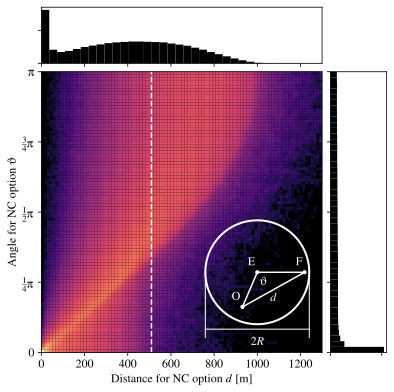

In [5]:
R = 509.8
rho = 12 / 1e6

fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.tick_params(axis="x", labelbottom=False)
ax_histx.tick_params(axis="y", labelleft=False)

    # the scatter plot:
ax.hist2d(d, theta, range=[[0, 1300],[0, math.pi]],bins = 100, norm=colors.LogNorm(), density=True, cmap='magma')
ax.set_facecolor('#000')

ax.set_yticks([0, math.pi  / 4 , math.pi  / 2 , math.pi  *3/ 4, math.pi])
ax.set_yticklabels(['$0$', r'$\frac{1}{4} \pi$', r'$\frac{1}{2} \pi$', r'$\frac{3}{4} \pi$', r'$\pi$' ])
ax.plot([R, R],[0, math.pi], '--', color='white')
##ax.plot([2*R, 2*R],[0, math.pi], '--', color='white')

center = (1000, math.pi / 3.5)
aspect = get_aspect(ax)
height = math.pi / 2.7
width = height * aspect
outer_circle = matplotlib.patches.Ellipse(center, width=width, height=height, fill=False, lw=2, ec='#fff', clip_on=False, zorder=30)
ax.add_patch(outer_circle)
ax.plot([center[0]- width /2, center[0] - width /2],[center[1], center[1] - height/2 -0.15], color='#fff', lw=1)
ax.plot([center[0]+ width /2, center[0] + width /2],[center[1], center[1] - height/2 -0.15], color='#fff', lw=1)
ax.plot([center[0]- width /2, center[0] + width /2],[center[1] - height/2 -0.055, center[1] - height/2 -0.055], color='#fff', lw=1)
ax.text(center[0], center[1] - height/2 -0.2, '$2R$', va='center', ha='center', color='#fff')

x = np.array([0, width / 2.2, - width /7 ]) + center[0]
y = np.array([0, 0, - height / 3]) + center[1]
ax.scatter(x, y, s=10, color='#fff', zorder=20)

ax.plot([x[0], x[1]],[y[0], y[1]], color='#fff')
ax.plot([x[1], x[2]],[y[1], y[2]], color='#fff')
ax.plot([x[2], x[0]],[y[2], y[0]], color='#fff')
ax.text(center[0]+ 10, center[1]- 0.05,'$\\vartheta$', ha='left', va='top', color='#fff')
ax.text(center[0]+ 60, center[1]- 0.23,'$d$', ha='left', va='top', color='#fff')

ax.text(center[0]-10, center[1]+ 0.05,'E', ha='right', va='bottom', color='#fff')
ax.text(x[1]-10, y[1]+ 0.05,'F', ha='right', va='bottom', color='#fff')
ax.text(x[2]-10, y[2]+ 0.05,'O', ha='right', va='bottom', color='#fff')

ax_histx.hist(d, bins=50, density=True, color='#000')
ax_histy.hist(theta, bins=50, orientation='horizontal', density=True, color='#000')

ax.set_ylabel('Angle for NC option $\\vartheta$')
ax.set_xlabel('Distance for NC option $d$ [m]')

fig.savefig(f"../figures/forwarding_options_q{q}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/forwarding_options_q{q}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
plt.show()

In [6]:
print('Fin')

Fin


In [7]:
# p_L = 0.5

d_OF = np.sqrt(np.power(df['forwarded_from_x'] - df['option_x'], 2) + np.power(df['forwarded_from_y'] - df['option_y'], 2))
d_OS = np.sqrt(np.power(df['forwarder_x'] - df['option_x'], 2) + np.power(df['forwarder_y'] - df['option_y'], 2))
d_SF = np.sqrt(np.power(df['forwarder_x'] - df['forwarded_from_x'], 2) + np.power(df['forwarder_y'] - df['forwarded_from_y'], 2))
alpha_OF = np.arccos(d_OF / (2*R))
alpha_OS = np.arccos(d_OS / (2*R))
alpha_SF = np.arccos(d_SF / (2*R))
overlap_OF = 2 * (alpha_OF * R**2 - d_OF*R /2 * np.sin(alpha_OF))
overlap_OS = 2 * (alpha_OS * R**2 - d_OS*R /2 * np.sin(alpha_OS))
overlap_SF = 2 * (alpha_SF * R**2 - d_SF*R /2 * np.sin(alpha_SF))

A = math.pi * R**2

xR = (1-p_L) * (A - overlap_SF) * rho
xR_NC =(1-p_L) * ((overlap_OF-overlap_OS) * (1-p_L) + (overlap_SF- overlap_OS) * (1-p_L) + (overlap_OS * p_L) -  (overlap_OS * p_L**2)) * rho
xR_NC_R = (1-p_L) * ((1-p_L)*p_L * overlap_SF + (A-overlap_SF)*(1-p_L)) * rho

# theta = np.arccos((np.power(d1,2) + np.power(d2,2) -np.power(d,2)) / (2 * d1 * d2))

# rho = 12 / 1000**2

/home/fu/.pyenv/versions/3.9.0/lib/python3.9/site-packages/polars/internals/series/series.py:988: RuntimeWarning: invalid value encountered in arccos
  series = f(lambda out: ufunc(*args, out=out, dtype=dtype_char, **kwargs))


In [8]:
# fig, ax = plt.subplots()
# data = (xR_NC - xR).to_numpy()
# data = data[np.logical_not(np.isnan(data))]

# step = 0.05
# cnts, bin_edges = np.histogram(data, bins=np.arange(-2,2, 0.05))
# bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
# ax.bar(bin_centers, cnts / np.sum(cnts), width=step)

# plt.show()

In [9]:
df = df.with_columns([pl.lit(xR).alias('xR'), pl.lit(xR_NC).alias('xR_NC'), pl.lit(xR_NC- xR).alias('delta_xR'), pl.lit(xR_NC_R).alias('xR_NC_R'), pl.lit(xR_NC_R- xR).alias('delta_xR_NC_R')])

In [10]:
delta_xR_max = df.groupby(['seqNo_with_run_id', 'forwarder']).agg(pl.col('delta_xR').max())
delta_xR_NC_R_max = df.groupby(['seqNo_with_run_id', 'forwarder']).agg(pl.col('delta_xR_NC_R').max())
xR = df.groupby(['seqNo_with_run_id', 'forwarder']).agg(pl.col('xR').max())

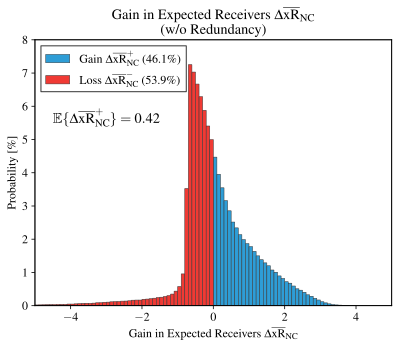

In [11]:
red = '#f03a34'
blue = '#2e9dd6'

fig, ax = plt.subplots()
gains_NC = delta_xR_max['delta_xR'].to_numpy()
gain_share = len(gains_NC[gains_NC > 0]) / len(gains_NC)
step = 0.1

cnts, bin_edges = np.histogram(gains_NC, bins=np.arange(-10, 10, step))
bar_heights = cnts / np.sum(cnts) * 100
bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
negative_bin_centers = bin_centers[bin_centers < 0]
negative_bar_heights = bar_heights[bin_centers < 0]
positive_bin_centers = bin_centers[bin_centers >= 0]
positive_bar_heights = bar_heights[bin_centers >= 0]
ax.bar(positive_bin_centers, positive_bar_heights, lw=0.5, ec="#333", color=blue, width=step, label=f'Gain $\Delta\overline{{\mathrm{{xR}}}}_\mathrm{{NC}}^{{+}}$ ({gain_share*100:.1f}\%)')
ax.bar(negative_bin_centers, negative_bar_heights, lw=0.5, ec="#333", width=step, color=red, label=f'Loss $\Delta\overline{{\mathrm{{xR}}}}_\mathrm{{NC}}^{{-}}$ ({(1-gain_share)*100:.1f}\%)')

ax.set_ylim([0, 8])
ax.set_xlim([-5, 5])
# {np.mean(gains_NC[gains_NC > 0]):.2f}
ax.set_ylabel('Probability [\%]')
ax.set_xlabel('Gain in Expected Receivers $\Delta\overline{\mathrm{xR}}_\mathrm{NC}$')

# Plot schematic
# aspect = get_aspect(ax)
# center = (0.17, 10)
# height = 6.2
# width = height * aspect
# stretch = 1.3
# mask = matplotlib.patches.Ellipse(center, width=width* stretch, height=height* stretch, fill=False, lw=0, clip_on=False)
# ax.add_patch(mask)

# circle = matplotlib.patches.Ellipse(center, width=width, height=height, fill=False, lw=1.2, ec='#333', clip_on=False, zorder=20)
# ax.add_patch(circle)
# circleP = matplotlib.patches.Ellipse(center, width=width, height=height, fill=True, fc='#ebebeb', lw=0, clip_on=False)
# ax.add_patch(circleP)

# center_F = (0.24, 9.8)
# circle_F = matplotlib.patches.Ellipse(center_F, width=width, height=height, fill=False, lw=1.2, ec='#333', clip_on=True, clip_path=mask, zorder=10)
# ax.add_patch(circle_F)
# circle_FP = matplotlib.patches.Ellipse(center_F, width=width, height=height, fill=True, fc="#fff", lw=0, hatch="//", clip_on=True, clip_path=circle)
# ax.add_patch(circle_FP)

# center_O = (0.09, 9.2)
# circle_O = matplotlib.patches.Ellipse(center_O, width=width, height=height, fill=False, lw=1.2, ec='#333', clip_path=mask, zorder=10)
# ax.add_patch(circle_O)
# circle_OP = matplotlib.patches.Ellipse(center_O, width=width, height=height, fill=False, lw=0, hatch="\\\\", clip_path=circle)
# ax.add_patch(circle_OP)

# s_OF = matplotlib.patches.Ellipse(center_O, width=width, height=height, fill=True, hatch="XX", fc="#fff", clip_path=circle_F)
# ax.add_patch(s_OF)

# x=[center[0], center_F[0], center_O[0]]
# y=[center[1], center_F[1], center_O[1]]
# ax.scatter(x, y, s=40, color='#fff', zorder=19)
# ax.scatter(x, y, s=20, color='#333', zorder=20)

# x_offset = 0.01
# y_offset = 0.15
# ax.text(center[0] - x_offset, center[1]+ y_offset,'E', ha='right', va='bottom', color='#333', bbox=dict(pad=3, fc='#fff', lw=1, color='#333', zorder=21), zorder=21)
# ax.text(x[1] - x_offset, y[1]+ y_offset,'F', ha='right', va='bottom', color='#333', bbox=dict(pad=3, fc='#fff', lw=1, color='#333', zorder=21), zorder=21)
# ax.text(x[2] - x_offset, y[2]+ y_offset,'O', ha='right', va='bottom', color='#333', bbox=dict(pad=3, fc='#fff', lw=1, color='#333', zorder=21), zorder=21)

ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)
ax2.bar([-11],[-11], ec='#333', color='#ebebeb', label="$A_0$")
ax2.bar([-11],[-11], ec='#333', color='#fff', hatch="//", label="$A_1$")
ax2.bar([-11],[-11], ec='#333', color='#fff', hatch="\\\\", label="$A_2$")
ax2.bar([-11],[-11], ec='#333', color='#fff', hatch="XX", label="$A_3$")
# leg = ax2.legend(fancybox=False, framealpha=1.0, loc="upper right", bbox_to_anchor=(1, 0.45))
# leg.get_frame().set_edgecolor('#333')

exp_gain = np.mean(gains_NC[gains_NC > 0]*gain_share)
ax.text(-4.5, 5.5, f'$\mathbb{{E}} \{{\Delta\overline{{\mathrm{{xR}}}}_\mathrm{{NC}}^{{+}} \}}= {exp_gain:.2f}$', fontsize='large')
leg = ax.legend(fancybox=False, framealpha=1.0, loc="upper left")
leg.get_frame().set_edgecolor('#333')

plt.title('Gain in Expected Receivers $\Delta\overline{\mathrm{xR}}_\mathrm{NC}$ \n(w/o Redundancy)')
fig.savefig(f"../figures/delta_xR_NC_q{q}_v1.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/delta_xR_NC_q{q}_v1.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
plt.show()

In [12]:
len(gains_NC[gains_NC > 0]) / len(gains_NC)

0.461432846981242

# Redundant NC

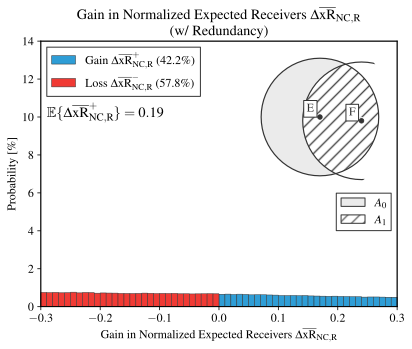

In [13]:

fig, ax = plt.subplots()
gains_NC_R = delta_xR_NC_R_max['delta_xR_NC_R'].to_numpy()
gain_share = len(gains_NC[gains_NC_R > 0]) / len(gains_NC_R)
step = 0.01

cnts, bin_edges = np.histogram(gains_NC_R, bins=np.arange(-2, 2, step))
bar_heights = cnts / np.sum(cnts) * 100
bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2
negative_bin_centers = bin_centers[bin_centers < 0]
negative_bar_heights = bar_heights[bin_centers < 0]
positive_bin_centers = bin_centers[bin_centers >= 0]
positive_bar_heights = bar_heights[bin_centers >= 0]
ax.bar(positive_bin_centers, positive_bar_heights, lw=0.5, ec="#333", color=blue, width=step, label=f'Gain $\Delta\overline{{\mathrm{{xR}}}}_\mathrm{{NC,R}}^{{+}}$ ({gain_share*100:.1f}\%)')
ax.bar(negative_bin_centers, negative_bar_heights, lw=0.5, ec="#333", width=step, color=red, label=f'Loss $\Delta\overline{{\mathrm{{xR}}}}_\mathrm{{NC,R}}^{{-}}$ ({(1-gain_share)*100:.1f}\%)')

ax.set_ylim([0, 14])
ax.set_xlim([-0.3, 0.3])
# {np.mean(gains_NC[gains_NC > 0]):.2f}
ax.set_ylabel('Probability [\%]')
ax.set_xlabel('Gain in Normalized Expected Receivers $\Delta\overline{\mathrm{xR}}_\mathrm{NC,R}$')

# Plot schematic
aspect = get_aspect(ax)
center = (0.17, 10)
height = 6.2
width = height * aspect
stretch = 1.3
mask = matplotlib.patches.Ellipse(center, width=width* stretch, height=height* stretch, fill=False, lw=0, clip_on=False)
ax.add_patch(mask)

circle = matplotlib.patches.Ellipse(center, width=width, height=height, fill=False, lw=1.2, ec='#333', clip_on=False, zorder=20)
ax.add_patch(circle)
circleP = matplotlib.patches.Ellipse(center, width=width, height=height, fill=True, fc='#ebebeb', lw=0, clip_on=False)
ax.add_patch(circleP)

center_F = (0.24, 9.8)
circle_F = matplotlib.patches.Ellipse(center_F, width=width, height=height, fill=False, lw=1.2, ec='#333', clip_on=True, clip_path=mask, zorder=10)
ax.add_patch(circle_F)
circle_FP = matplotlib.patches.Ellipse(center_F, width=width, height=height, fill=True, fc="#fff", lw=0, hatch="//", clip_on=True, clip_path=circle)
ax.add_patch(circle_FP)

x=[center[0], center_F[0]]
y=[center[1], center_F[1]]
ax.scatter(x, y, s=40, color='#fff', zorder=19)
ax.scatter(x, y, s=20, color='#333', zorder=20)

x_offset = 0.01
y_offset = 0.15
ax.text(center[0] - x_offset, center[1]+ y_offset,'E', ha='right', va='bottom', color='#333', bbox=dict(pad=3, fc='#fff', lw=1, color='#333', zorder=21), zorder=21)
ax.text(x[1] - x_offset, y[1]+ y_offset,'F', ha='right', va='bottom', color='#333', bbox=dict(pad=3, fc='#fff', lw=1, color='#333', zorder=21), zorder=21)

ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)
ax2.bar([-1],[-1], ec='#333', color='#ebebeb', label="$A_0$")
ax2.bar([-1],[-1], ec='#333', color='#fff', hatch="//", label="$A_1$")
leg = ax2.legend(fancybox=False, framealpha=1.0, loc="upper right", bbox_to_anchor=(1, 0.45))
leg.get_frame().set_edgecolor('#333')


exp_gain = np.mean(gains_NC_R[gains_NC_R > 0]*gain_share)
ax.text(-0.29, 10, f'$\mathbb{{E}} \{{\Delta\overline{{\mathrm{{xR}}}}_\mathrm{{NC,R}}^{{+}} \}}= {exp_gain:.2f}$', fontsize='large')

leg = ax.legend(fancybox=False, framealpha=1.0, loc="upper left")
leg.get_frame().set_edgecolor('#333')

plt.title('Gain in Normalized Expected Receivers $\Delta\overline{\mathrm{xR}}_\mathrm{NC,R}$ \n(w/ Redundancy)')
fig.savefig(f"../figures/delta_xR_NC_R_q{q}_v1.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/delta_xR_NC_R_q{q}_v1.png", dpi=500, bbox_inches='tight', pad_inches=0.01)
plt.show()


In [14]:
print(exp_gain,np.sum(positive_bar_heights * positive_bin_centers / 100))

0.1874904155703216 0.18749626605468975


In [15]:
np.mean(list(xR['xR'].to_numpy()))

nan

In [16]:
xR = xR['xR'].to_numpy()
xR_clean = xR[~np.isnan(xR)]

In [17]:
0.42/np.mean(xR_clean)

SeriesView(0.15154984)